## Init

In [1]:
! pip install segmentation_models_pytorch albumentations
! pip install -U git+https://github.com/albu/albumentations --no-cache-dir


     |████████████████████████████████| 88 kB 922 kB/s 
     |████████████████████████████████| 58 kB 2.3 MB/s 
     |████████████████████████████████| 376 kB 3.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=ec9a6b0b01123794b75471abf24805b54a587b391b2c786d1ae47ce51e1ab029
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60963 sha256=100f4cbefe748620b6562caaa6a6f4aa713d3191120f1879dc3f5d1fc75f06c4
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-6ey4w9g8
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-6ey4w9g8
  Created wheel for albumentations

In [2]:

import os
import csv
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import cv2
from tqdm.notebook import tqdm
from glob import glob
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

import shutil

import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import albumentations
import torchvision 
from torchvision import transforms, models

import random

import segmentation_models_pytorch as smp
from PIL import Image

In [3]:
!ls

__notebook__.ipynb


## Main

In [4]:
ROOT = "/kaggle/input/ultrasound-nerve-segmentation/"
trainpath = "/kaggle/input/ultrasound-nerve-segmentation/train/"
testpath = "/kaggle/input/ultrasound-nerve-segmentation/test/"

masks = [os.path.join(trainpath,i) for i in os.listdir(trainpath) if "mask" in i]
imgs = [i.replace("_mask","") for i in masks]

df = pd.DataFrame({"image":imgs,"mask":masks})

df_train, df_val = train_test_split(df,test_size = 0.15)
print(df_train.values.shape)
print(df_val.values.shape)

(4789, 2)
(846, 2)


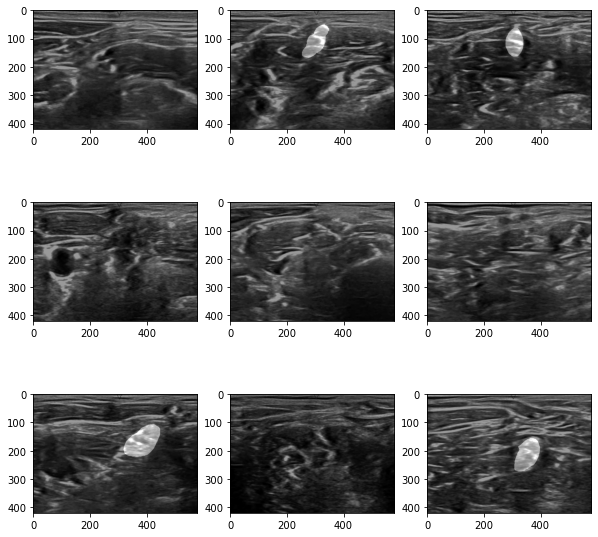

In [5]:
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    ii = random.randint(0, len(df))
    fig.add_subplot(rows,cols,i)
    img_path=df['image'][ii]
    msk_path=df['mask'][ii]
    plt.imshow(np.array(Image.open(img_path)), cmap = 'gray')
    plt.imshow(np.array(Image.open(msk_path)),alpha=0.4, cmap = 'gray')
plt.show()

In [6]:
def rle_encoding(x):
    dots = np.where(x.T.flatten()==1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def convert_to_tensor(x,**kwargs):
    return x.transpose(2,0,1).astype("float32")

def func_for_preprocessing(preprocessing_fn=None):
    transform = []
    if preprocessing_fn:
        transform.append(albumentations.Lambda(image=preprocessing_fn))
    transform.append(albumentations.Lambda(image=convert_to_tensor))
    return albumentations.Compose(transform)

def trainaugs():
    transform =  [
                albumentations.Resize(height=224,width=224,interpolation=Image.BILINEAR),
                albumentations.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0),
                albumentations.ShiftScaleRotate(rotate_limit=15, shift_limit=0.15, scale_limit=0.2),
                albumentations.HorizontalFlip(),
            ]
    return albumentations.Compose(transform)

def valaugs():
    transform = [
                albumentations.Resize(height=224,width=224,interpolation=Image.BILINEAR),
            ]
    return albumentations.Compose(transform)


class GetDataset(Dataset):
    def __init__(self,imagespath,maskspath,augment=None,preprocess=None):
        self.imagespath = imagespath
        self.maskspath = maskspath
        self.augment = augment
        self.preprocess = preprocess
        
    def __len__(self):
        return len(self.imagespath)
    
    def __getitem__(self,idx):
        image = cv2.cvtColor(cv2.imread(self.imagespath[idx]),cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskspath[idx], cv2.IMREAD_GRAYSCALE)

        if self.augment:
            sample = self.augment(image=image, mask=mask)
            image,mask = sample['image'],sample['mask']
        if self.preprocess:
            sample = self.preprocess(image=image,mask=mask)
            image,mask = sample['image'],sample['mask']

        mask = (mask / 255).astype(np.float32)
        mask = np.expand_dims(mask, axis=0)

        return image,mask

In [7]:
encoder = "resnet34"
encoder_wts = "imagenet"
activation = "sigmoid"


model = smp.Unet(encoder_name=encoder,activation=activation,encoder_weights=encoder_wts)
preprocess_func = smp.encoders.get_preprocessing_fn(encoder,encoder_wts)


traindata = GetDataset(imagespath = df_train['image'].tolist(),
                            maskspath = df_train['mask'].tolist(),
                            augment = trainaugs(),
                            preprocess = func_for_preprocessing(preprocess_func))

validationdata = GetDataset(imagespath = df_val['image'].tolist(),
                            maskspath = df_val['mask'].tolist(),
                            augment = valaugs(),
                           preprocess = func_for_preprocessing(preprocess_func))

batch_size = 16
trainloader = DataLoader(traindata,batch_size = batch_size,shuffle=True)
valloader = DataLoader(validationdata,batch_size=batch_size,shuffle=False)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [8]:
trainmodel = True
epochs = 20
device = "cuda"
loss = smp.utils.losses.DiceLoss()
metrics = [ smp.utils.metrics.IoU(threshold=0.5) ]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

trainepoch = smp.utils.train.TrainEpoch(model,loss=loss,optimizer=optimizer,metrics=metrics,device=device,verbose=True)
validepoch = smp.utils.train.ValidEpoch(model,loss=loss,metrics=metrics,device=device,verbose=True)


In [9]:
best_iou_score = 0.0 
train_logs_list, valid_logs_list = [], []
for i in range(0,epochs):
    print('\nEpoch: {}'.format(i))
    trainlogs = trainepoch.run(trainloader)
    validlogs = validepoch.run(valloader)
    lr_scheduler.step()

    train_logs_list.append(trainlogs)
    valid_logs_list.append(validlogs)
    if best_iou_score < validlogs['iou_score']:
        best_iou_score = validlogs['iou_score']
        torch.save(model, './best_model.pth')


Epoch: 0
valid: 100%|██████████| 53/53 [00:17<00:00,  2.95it/s, dice_loss - 0.442, iou_score - 0.396]

Epoch: 1
valid: 100%|██████████| 53/53 [00:08<00:00,  6.06it/s, dice_loss - 0.6247, iou_score - 0.2346]

Epoch: 2
valid: 100%|██████████| 53/53 [00:08<00:00,  5.94it/s, dice_loss - 0.4124, iou_score - 0.4221]

Epoch: 3
valid: 100%|██████████| 53/53 [00:08<00:00,  6.04it/s, dice_loss - 0.4059, iou_score - 0.4289]

Epoch: 4
valid: 100%|██████████| 53/53 [00:09<00:00,  5.75it/s, dice_loss - 0.4383, iou_score - 0.3979]

Epoch: 5
valid: 100%|██████████| 53/53 [00:08<00:00,  6.02it/s, dice_loss - 0.4047, iou_score - 0.4297]

Epoch: 6
valid: 100%|██████████| 53/53 [00:09<00:00,  5.77it/s, dice_loss - 0.4077, iou_score - 0.4255]

Epoch: 7
valid: 100%|██████████| 53/53 [00:08<00:00,  5.92it/s, dice_loss - 0.4289, iou_score - 0.4069]

Epoch: 8
valid: 100%|██████████| 53/53 [00:08<00:00,  6.09it/s, dice_loss - 0.3893, iou_score - 0.446]

Epoch: 9
valid: 100%|██████████| 53/53 [00:09<00:00,  5.7

In [10]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)


In [11]:
train_logs_df.to_csv('train_logs_df.csv',index=False)
valid_logs_df.to_csv('valid_logs_df.csv',index=False)

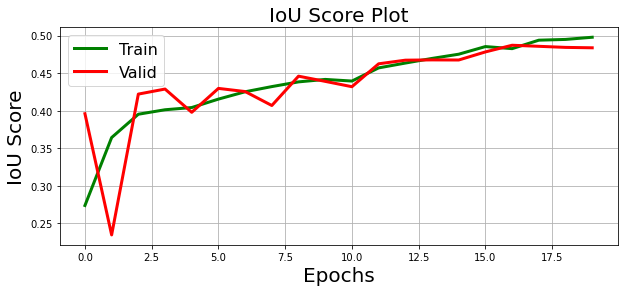

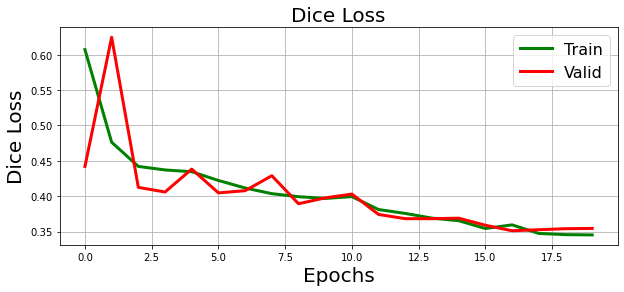

In [12]:
plt.figure(figsize=(10,4))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(),'g-',lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(),'r-' ,lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(),'g-',lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(),'r-' ,lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.show()

## Test best saved model

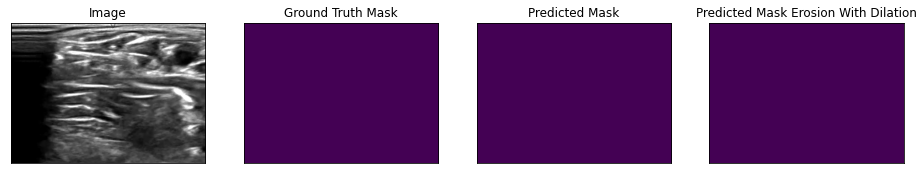

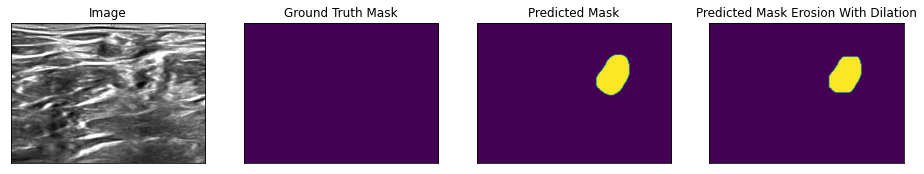

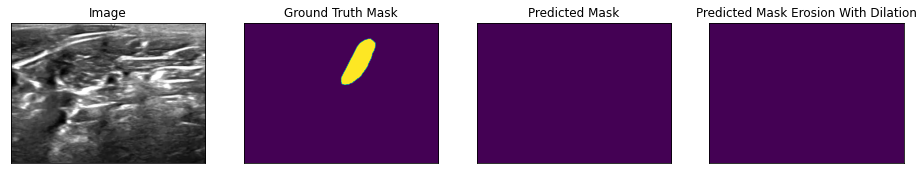

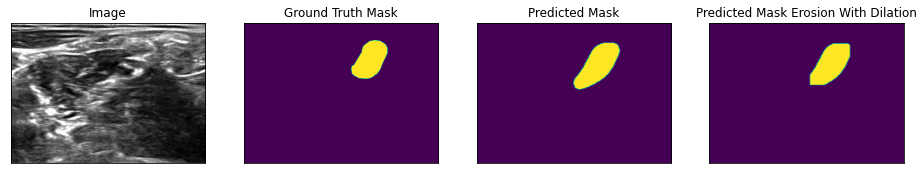

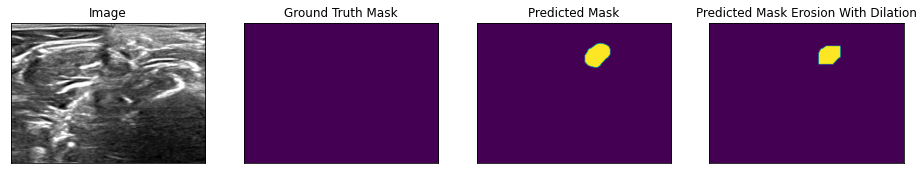

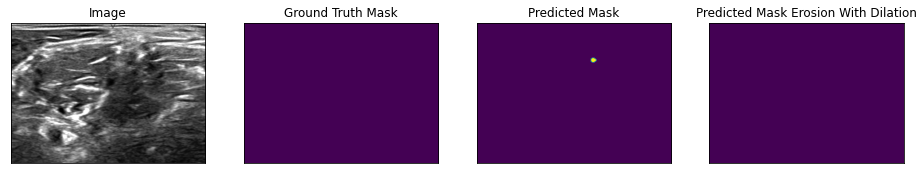

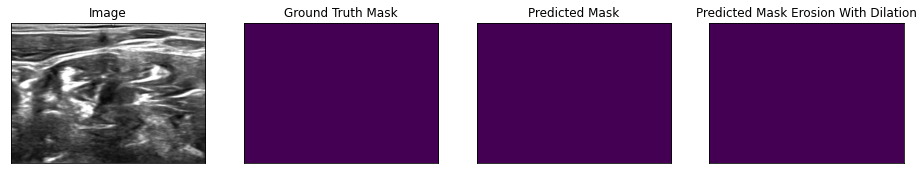

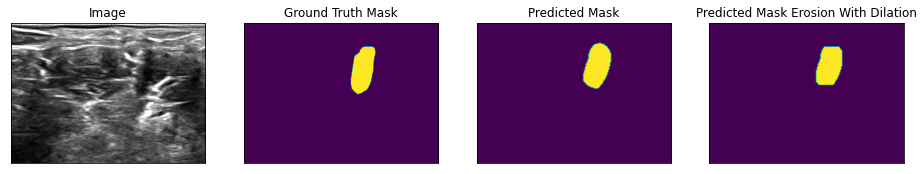

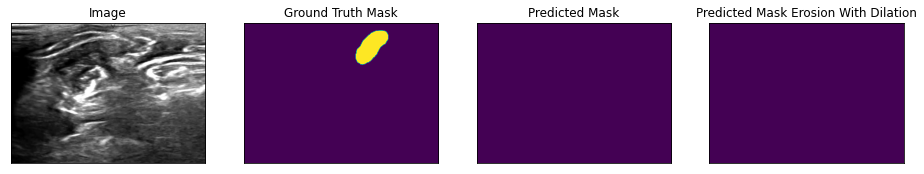

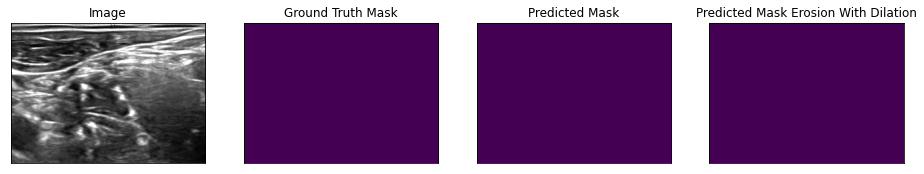

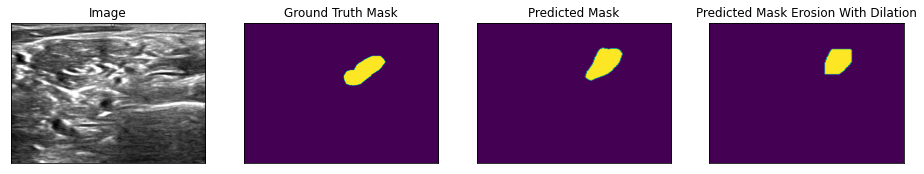

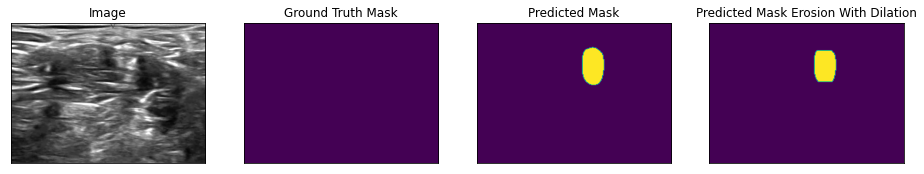

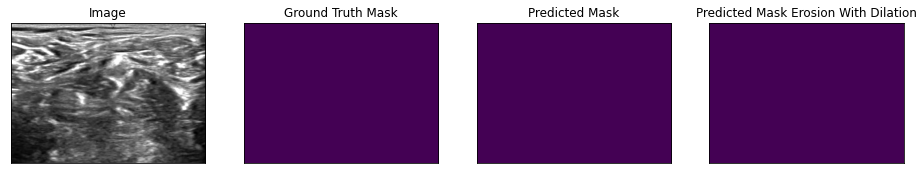

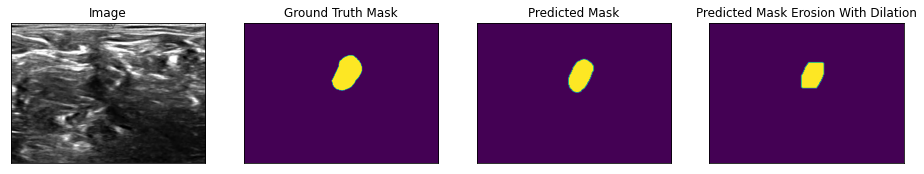

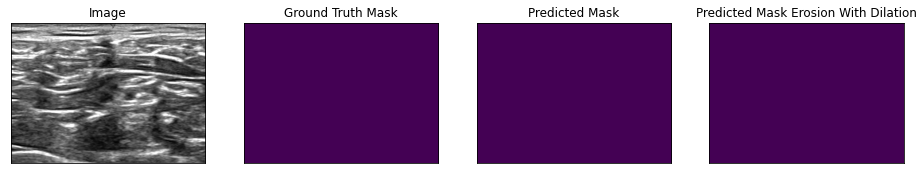

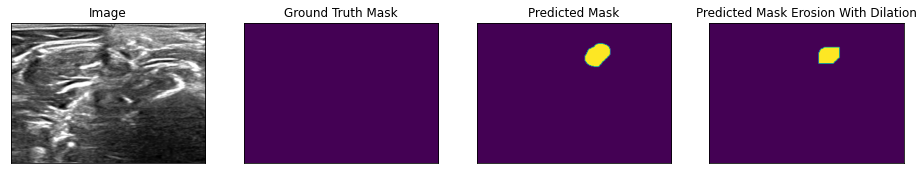

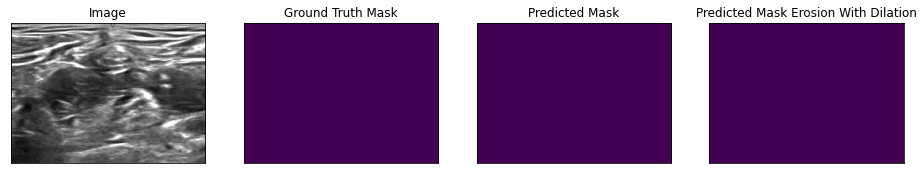

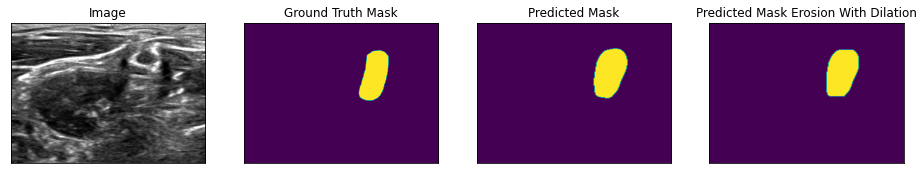

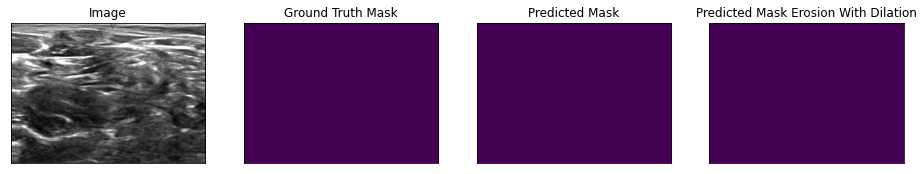

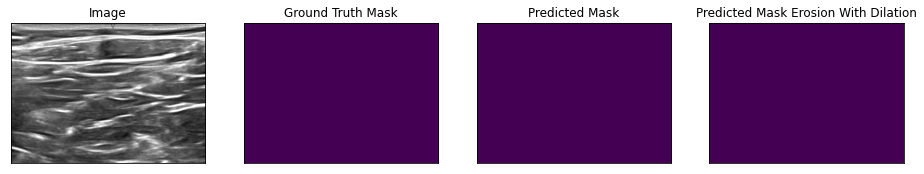

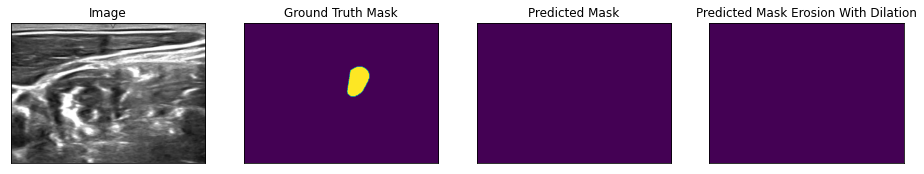

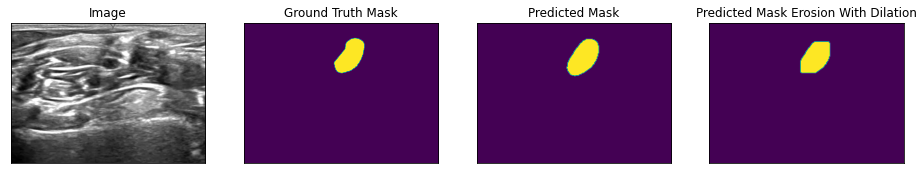

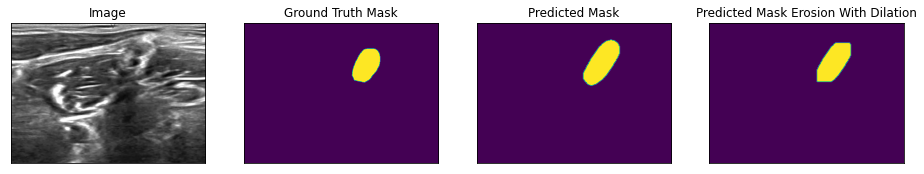

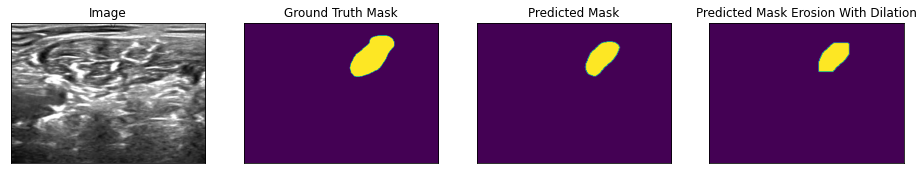

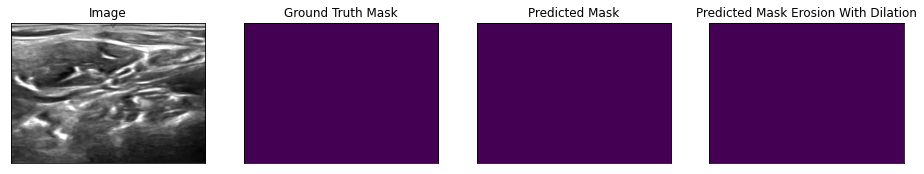

In [13]:
best_model = torch.load('./best_model.pth')

test_dataset = GetDataset(imagespath = df_val['image'].tolist(),
                            maskspath = df_val['mask'].tolist(),
                            augment = valaugs(),
                           preprocess = func_for_preprocessing(preprocess_func))


test_dataset_vis = GetDataset(imagespath = df_val['image'].tolist(),
                            maskspath = df_val['mask'].tolist())


def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if image.shape[0] == 3:
            image = image.transpose([1, 2, 0])
        plt.imshow(image)
    plt.show()

for i in range(25):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    mask_vis = test_dataset_vis[n][1].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().numpy().round()

    kernel = np.ones((5,5),np.uint8)
    pr_mask_er = cv2.erode(pr_mask,kernel,iterations = 4)
    pr_mask_er = cv2.dilate(pr_mask_er,kernel,iterations = 4)

    pr_mask = cv2.resize(pr_mask, (580, 420))
    pr_mask_er = cv2.resize(pr_mask_er, (580, 420))

    mask_vis = mask_vis.squeeze()

    visualize(
        image=image_vis, 
        ground_truth_mask=mask_vis, 
        predicted_mask=pr_mask,
        predicted_mask_erosion_with_dilation=pr_mask_er
    )

## Test evaluation

In [14]:
imgs = [f for f in os.listdir(testpath)]
imgs = sorted(imgs, key=lambda s: int(s.split('.')[0]))

encodings = []

for m in tqdm(imgs):
    x = cv2.imread(os.path.join(testpath, m))

    x = valaugs()(image=x)['image']
    x = func_for_preprocessing(preprocess_func)(image=x)['image']

    x_tensor = torch.from_numpy(x).to(device).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)

    pr_mask = pr_mask.squeeze().cpu().numpy().round().astype(np.uint8)
    pr_mask = albumentations.Resize(height=420,width=580,interpolation=Image.NEAREST)(image=pr_mask)['image']

    encodings.append(rle_encoding(pr_mask))

  0%|          | 0/5508 [00:00<?, ?it/s]

In [15]:
df_submission = pd.DataFrame(columns=["img", "pixels"])
for i, encoding in enumerate(encodings):
    pixels = ' '.join(map(str, encoding))
    df_submission.loc[i] = [str(i+1), pixels]

df_submission.to_csv('submission.csv', index=False)